## Access Kaggle
Serveral things you need to do to access Kaggle
- Sign in to Kaggle and join the competition called **BCI Homework 3 Kaggle Judge** (using the link we provide in the document)

- Create your own kaggle API token (in your account->API)
  
  <img src="https://i.imgur.com/Gia6TwE.png" alt="drawing" width="800"/>
- Upload API token (.json file) to Colab

   <img src="https://i.imgur.com/xjEXBYs.png" alt="drawing" width="200"/>

In [ ]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions list

ref                                                                               deadline             category            reward  teamCount  userHasEntered  
--------------------------------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
https://www.kaggle.com/competitions/llm-detect-ai-generated-text                  2024-01-22 23:59:00  Featured          $110,000       2418           False  
https://www.kaggle.com/competitions/optiver-trading-at-the-close                  2023-12-20 23:59:00  Featured          $100,000       4074           False  
https://www.kaggle.com/competitions/nfl-big-data-bowl-2024                        2024-01-08 23:59:00  Analytics         $100,000          0           False  
https://www.kaggle.com/competitions/blood-vessel-segmentation                     2024-02-06 23:59:00  Research           $80,000        251           False  
https://www.kaggle.com/competitions/linking-wr

## Download Dataset from Kaggle

In [ ]:
!kaggle competitions download -c bci-homework-3-kaggle-judge-fall
!unzip -qq bci-homework-3-kaggle-judge-fall.zip -d ./
!ls -l BCI_hw3_dataset

 95% 269M/282M [00:03<00:00, 75.6MB/s]
100% 282M/282M [00:03<00:00, 79.4MB/s]
total 16
-rw-r--r-- 1 root root  269 Nov 16 05:01 data_detail.json
drwxr-xr-x 2 root root 4096 Dec 12 17:54 labeled_test
drwxr-xr-x 2 root root 4096 Dec 12 17:54 train
drwxr-xr-x 2 root root 4096 Dec 12 17:54 unlabeled_test


## Install Package (Optional)

In [ ]:
!pip install torchinfo
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 26.2 MB/s eta 0:00:00


## Import Package and Library to Python Session

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.nn.functional as F

from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy.io import savemat
import numpy as np
import math
import time
import csv
import mne
import sys
import os

DATASET_DIR = "BCI_hw3_dataset/train"
DATASET_DIR_TEST = "BCI_hw3_dataset/labeled_test"
DATASET_DIR_EXAM = "BCI_hw3_dataset/unlabeled_test"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## EEG Model

### EEGNet

In [ ]:
class EEGNet(nn.Module):
    """EEGNet model from Lawhern et al 2018.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    kernLength: int
        Length of temporal convolution in first layer.
    F1, F2: int
        Number of temporal filters (F1) and number of pointwise filters (F2) to learn.
    D: int
        Number of spatial filters to learn within each temporal convolution.
    dropoutRate: float
        Dropout ratio.
    ... References ............
    https://arxiv.org/abs/1611.08024
    """
    def __init__(self, C, N, nb_classes, kernLength=64, F1=8, F2=16, D=2, dropoutRate=0.5):
        super(EEGNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, F1, (1, kernLength), padding="valid", bias=False),
            nn.BatchNorm2d(F1, eps=1e-3, momentum=0.99)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                F1, D * F1, (C, 1), groups=F1, bias=False
            ),
            nn.BatchNorm2d(D * F1, eps=1e-3, momentum=0.99),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(dropoutRate)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                D * F1, D * F1, (1, 16),
                padding=(0, 8), groups=D * F1, bias=False
            ),
            nn.Conv2d(D * F1, F2, (1, 1), bias=False),
            nn.BatchNorm2d(F2, eps=1e-3, momentum=0.99),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(dropoutRate)
        )

        fc_inSize = self.get_size(C, N)[1]
        self.classifier = nn.Linear(fc_inSize, nb_classes, bias=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size()[0], -1)
        x = self.classifier(x)
        return x

    def get_size(self, C, N):
        data = torch.ones((1, 1, C, N))
        x = self.conv1(data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size()[0], -1)
        return x.size()


### SCCNet

In [ ]:
# (Bonus) Optional TODO: Advanced SCCNet model without permutation layer
class SCCNet_v2(nn.Module):
    """Advanced SCCNet model without permutation layer.
    ... Parameters ............
    C: int
        Number of EEG input channels.
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    Nu: int
        Number of spatial kernel.
    Nt: int
        Length of spatial kernel.
    Nc: int
        Number of spatial-temporal kernel.
    fs: float
        Sampling frequency of EEG input.
    dropoutRate: float
        Dropout ratio.
    ... References ............
    https://ieeexplore.ieee.org/document/8716937
    """
    def __init__(self, C, N, nb_classes, Nu=None, Nt=1, Nc=20, fs=1000.0, dropoutRate=0.5):
        super(SCCNet_v2, self).__init__()
        Nu = C if Nu is None else Nu
        # self.layer = ...

    def forward(self, x):
        return x


In [ ]:
# TODO: finish the SCCNet:
class SCCNet(nn.Module):
    """SCCNet model from Wei et al 2019.
    Note: Nc was misused in the paper to describe both the number of EEG input channels and the number of spatial-temporal kernel.
    Please refer to the following description to find the correspondence of the defined parameters and noataions in the paper.
    ... Parameters ............
    C: int
        Number of EEG input channels. (Same as the Nc mentioned in the first and second paragraphs of the paper section II.B)
    N: int
        Number of EEG input time samples.
    nb_classes: int
        Number of classes to predict.
    Nu: int
        Number of spatial kernel.
    Nt: int
        Length of spatial kernel.
    Nc: int
        Number of spatial-temporal kernel. (Same as the Nc mentioned in the third paragraph of the paper section II.B)
    fs: float
        Sampling frequency of EEG input.
    dropoutRate: float
        Dropout ratio.
    ... References ............
    https://ieeexplore.ieee.org/document/8716937
    """
    # You can only add extra argument to this function, do NOT remove the existed arguments
    # The model structure should be dynamic changed by the provided arguments,
    # There will be a score penalty if SCCNet structure is static
    def __init__(self, C, N, nb_classes, Nu=None, Nt=1, Nc=20, fs=1000.0, dropoutRate=0.5):
        super(SCCNet, self).__init__()
        Nu = C if Nu is None else Nu
        ### TODO: construct the model layers, refer to paper ###
        # self.layer = ...
        # First convolution block
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, Nu, kernel_size = (C, Nt), padding = 0, bias = False),
            Permute2d(shape = (0, 2, 1, 3)),  # Permute the dimensions
            nn.BatchNorm2d(1, eps=1e-3, momentum=0.99)
        )

        # Second convolution block
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(1, Nc, kernel_size = (Nu, 12), padding = 0, bias = False),
            nn.BatchNorm2d(Nc, eps=1e-3, momentum=0.99)
        )

        # Dropout layer
        self.dropout = nn.Dropout(dropoutRate)

        # Average pooling layer
        self.avg_pool = nn.AvgPool2d((1, 62), stride=(1, 12))

        fc_size = self.get_size(C, N)[1]

        # Fully connected layer
        self.fc = nn.Linear(fc_size, nb_classes, bias = True)

    def forward(self, x):
        ### TODO: forwarding rule ###
        # ex. x = self.layer(x)
        # note. remember the square activation and log activation
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = torch.square(x)
        x = self.dropout(x)
        x = self.avg_pool(x)
        x = torch.log(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

    def get_size(self, C, N):
        # Optional TODO: auto calculate fully-connected layer helper function
        data = torch.ones((1, 1, C, N))
        x = self.conv_block1(data)
        x = self.conv_block2(x)
        x = self.avg_pool(x)
        x = x.view(x.size()[0], -1)
        return x.size()

class Permute2d(nn.Module):
    def __init__(self, shape):
        super(Permute2d, self).__init__()
        self.shape = shape

    def forward(self, x):
        return torch.permute(x, self.shape)

## Train

In [ ]:
# config training scheme, mode, hyperparam
eegmodel = SCCNet # function alias, should be EEGNet, SCCNet, SCCNet_v2
kwargs = dict(Nt=22, Nc=20, fs=125.0, dropoutRate=0.5) # custom args for different EEG model
#kwargs = dict(kernLength=32, F1=16, F2=32, D=2, dropoutRate=0.2) # for EEGNet
scheme = "all"  # "all", "easy"
easy_list = ["01", "02", "03", "04"]  #TODO: Modify this list!!! Put the easy subject id here ex. ["01", "02" ......]
epochs = 350
batch_size = 64
lr = 1e-4
savepath = "/content/checkpoints/"
os.makedirs(savepath, exist_ok=True)

subject_id = "01"

### load data(all)

In [ ]:
# In this section, we need to create 2 dataloader, easy, all
mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat"))
x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()
x_train = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_train = np.zeros((0, ), dtype=y_data.dtype)
x_valid = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_valid = np.zeros((0, ), dtype=y_data.dtype)
### for tra_all_loader and val_all_loader
for sid in [f"{i:02d}" for i in range(1, 10)]:
    if sid == subject_id:
        continue
    mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{sid}_T.mat"))
    x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()

    for c in range(4):
        x_, y_ = x_data[y_data == c], y_data[y_data == c]
        x_train = np.append(x_train, x_[:54], axis=0)
        y_train = np.append(y_train, y_[:54], axis=0)
        x_valid = np.append(x_valid, x_[54:], axis=0)
        y_valid = np.append(y_valid, y_[54:], axis=0)


# numpy array to tensor
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).long()
x_valid = torch.from_numpy(x_valid)
y_valid = torch.from_numpy(y_valid).long()

# tensor reshape for training
x_train = x_train.unsqueeze(1)
y_train = F.one_hot(y_train, 4)
x_valid = x_valid.unsqueeze(1)
y_valid = F.one_hot(y_valid, 4)

print("train: {}, {}".format(x_train.size(), y_train.size()))
print("valid: {}, {}".format(x_valid.size(), y_valid.size()))

# build training and validation dataloader
trainset = torch.utils.data.TensorDataset(x_train, y_train)
validset = torch.utils.data.TensorDataset(x_valid, y_valid)
tra_all_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_all_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2)

train: torch.Size([1728, 1, 22, 562]), torch.Size([1728, 4])
valid: torch.Size([576, 1, 22, 562]), torch.Size([576, 4])


### load data (easy)

In [ ]:
# In this section, we need to create 2 dataloader, easy, all
mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat"))
x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()
x_train = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_train = np.zeros((0, ), dtype=y_data.dtype)
x_valid = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_valid = np.zeros((0, ), dtype=y_data.dtype)
### for tra_easy_loader and val_easy_loader
### TODO ###
### Create the data according to easy_list ###
for sid in easy_list:
    if sid == subject_id:
        continue
    mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{sid}_T.mat"))
    x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()

    for c in range(4):
        x_, y_ = x_data[y_data == c], y_data[y_data == c]
        x_train = np.append(x_train, x_[:54], axis=0)
        y_train = np.append(y_train, y_[:54], axis=0)
        x_valid = np.append(x_valid, x_[54:], axis=0)
        y_valid = np.append(y_valid, y_[54:], axis=0)

# numpy array to tensor
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).long()
x_valid = torch.from_numpy(x_valid)
y_valid = torch.from_numpy(y_valid).long()

# tensor reshape for training
x_train = x_train.unsqueeze(1)
y_train = F.one_hot(y_train, 4)
x_valid = x_valid.unsqueeze(1)
y_valid = F.one_hot(y_valid, 4)

print("train: {}, {}".format(x_train.size(), y_train.size()))
print("valid: {}, {}".format(x_valid.size(), y_valid.size()))

# build training and validation dataloader
trainset = torch.utils.data.TensorDataset(x_train, y_train)
validset = torch.utils.data.TensorDataset(x_valid, y_valid)
tra_easy_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_easy_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2)

train: torch.Size([648, 1, 22, 562]), torch.Size([648, 4])
valid: torch.Size([216, 1, 22, 562]), torch.Size([216, 4])


### training stage

In [ ]:
# train an epoch, evaluate an epoch
# if you are familiar with Pytorch, you CAN custom these function
#  such as adding the lr_scheduler to optimize the training progress

def train_an_epoch(model, data_loader, loss_fn, optimizer, lr_scheduler = None):
    model.train()

    a, b = 0, 0  # hit sample, total sample
    epoch_loss = np.zeros((len(data_loader), ))
    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device, dtype=torch.float)

        # Zero the gradients
        optimizer.zero_grad()

        # Get prediction
        output = model(x_batch)

        # Calculate loss
        loss = loss_fn(output, y_batch)

        # Backpropagation
        loss.backward()

        # update parameters
        optimizer.step()

        if lr_scheduler != None:
          lr_scheduler.step()

        epoch_loss[i] = loss.item()
        b += y_batch.size(0)
        a += torch.sum(y_batch.argmax(dim=1) == output.argmax(dim=1)).item()

    return epoch_loss.mean(), a / b  # return the loss and acc

def evalate_an_epoch(model, data_loader, loss_fn):
    model.eval()
    a, b = 0, 0  # hit sample, total sample
    epoch_loss = np.zeros((len(data_loader), ))
    with torch.no_grad():  # No gradient computation during evaluation
        for i, (x_batch, y_batch) in enumerate(data_loader):
            x_batch, y_batch = x_batch.to(device, dtype=torch.float), y_batch.to(device, dtype=torch.float)

            # Get prediction
            output = model(x_batch)

            # Calculate loss
            loss = loss_fn(output, y_batch)

            epoch_loss[i] = loss.item()
            b += y_batch.size(0)
            a += torch.sum(y_batch.argmax(dim=1) == output.argmax(dim=1)).item()

    return epoch_loss.mean(), a / b  # return the loss and acc


In [ ]:
model = eegmodel(x_train.size(2), x_train.size(3), 4, **kwargs).to(device)
loss_fn = nn.CrossEntropyLoss()  # loss function, can be modified
opt_fn = torch.optim.Adam(model.parameters(), lr=lr)  # optimizer, CAN be modified
sche_fn = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_fn, mode='min', factor=0.1, patience=10, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08) # optional

# dump the model structure
summary(model, input_size=(batch_size, *list(x_train.size()[1:])))

Layer (type:depth-idx)                   Output Shape              Param #
SCCNet                                   [64, 4]                   --
├─Sequential: 1-1                        [64, 1, 22, 541]          --
│    └─Conv2d: 2-1                       [64, 22, 1, 541]          10,648
│    └─Permute2d: 2-2                    [64, 1, 22, 541]          --
│    └─BatchNorm2d: 2-3                  [64, 1, 22, 541]          2
├─Sequential: 1-2                        [64, 20, 1, 530]          --
│    └─Conv2d: 2-4                       [64, 20, 1, 530]          5,280
│    └─BatchNorm2d: 2-5                  [64, 20, 1, 530]          40
├─Dropout: 1-3                           [64, 20, 1, 530]          --
├─AvgPool2d: 1-4                         [64, 20, 1, 40]           --
├─Linear: 1-5                            [64, 4]                   3,204
Total params: 19,174
Trainable params: 19,174
Non-trainable params: 0
Total mult-adds (M): 547.98
Input size (MB): 3.17
Forward/backward pass size

In [ ]:
# if you are familiar with Pytorch, you CAN customize the following training loop
## TODO ##
curriculum_learning = True # True when curriculum learning / False when normal SI training scheme or normal SI+FT training scheme
if curriculum_learning:
    hist = dict(
        loss=np.zeros((epochs, )), val_loss=np.zeros((epochs, )),
        acc=np.zeros((epochs, )), val_acc=np.zeros((epochs, ))
    )
    clock_ini = time.time()
    ### TODO : Modify the loader according to your curriculum training scheme ###
    ### ex. tra_all_loader, val_all_loader, tra_easy_loader, val_easy_loader
    tra_loader = tra_all_loader
    val_loader = val_all_loader
    for ep in range(int(epochs/2)):
        loss, acc = train_an_epoch(model, tra_loader, loss_fn, opt_fn)
        loss, acc = evalate_an_epoch(model, tra_loader, loss_fn)
        val_loss, val_acc = evalate_an_epoch(model, val_loader, loss_fn)
        print("Epoch {}: loss={:.4f}, acc={:.4f}, val_loss={:.4f}, val_acc={:.4f}".format(ep, loss, acc, val_loss, val_acc))
        hist["loss"][ep] = loss
        hist["acc"][ep] = acc
        hist["val_loss"][ep] = val_loss
        hist["val_acc"][ep] = val_acc
    ### TODO
    ### ex. tra_all_loader, val_all_loader, tra_easy_loader, val_easy_loader
    tra_loader = tra_all_loader
    val_loader = val_all_loader
    for ep in range(int(epochs/2)):
        loss, acc = train_an_epoch(model, tra_loader, loss_fn, opt_fn)
        loss, acc = evalate_an_epoch(model, tra_loader, loss_fn)
        val_loss, val_acc = evalate_an_epoch(model, val_loader, loss_fn)
        print("Epoch {}: loss={:.4f}, acc={:.4f}, val_loss={:.4f}, val_acc={:.4f}".format(ep+int(epochs/2), loss, acc, val_loss, val_acc))
        hist["loss"][ep+int(epochs/2)] = loss
        hist["acc"][ep+int(epochs/2)] = acc
        hist["val_loss"][ep+int(epochs/2)] = val_loss
        hist["val_acc"][ep+int(epochs/2)] = val_acc


        if True:
            checkpoint = dict(epoch=-1, state_dict=model.state_dict(), loss=loss, val_loss=val_loss)
            torch.save(checkpoint, os.path.join(savepath, f"TORCH_MODEL_NAME-ep{ep}.pth"))
    print("time spend: {:.2f} sec".format(time.time() - clock_ini))

else:
    hist = dict(
        loss=np.zeros((epochs, )), val_loss=np.zeros((epochs, )),
        acc=np.zeros((epochs, )), val_acc=np.zeros((epochs, ))
    )
    clock_ini = time.time()
    for ep in range(epochs):
        loss, acc = train_an_epoch(model, tra_all_loader, loss_fn, opt_fn)
        loss, acc = evalate_an_epoch(model, tra_all_loader, loss_fn)
        val_loss, val_acc = evalate_an_epoch(model, val_all_loader, loss_fn)
        print("Epoch {}: loss={:.4f}, acc={:.4f}, val_loss={:.4f}, val_acc={:.4f}".format(ep, loss, acc, val_loss, val_acc))
        hist["loss"][ep] = loss
        hist["acc"][ep] = acc
        hist["val_loss"][ep] = val_loss
        hist["val_acc"][ep] = val_acc

        if True:
            checkpoint = dict(epoch=-1, state_dict=model.state_dict(), loss=loss, val_loss=val_loss)
            torch.save(checkpoint, os.path.join(savepath, f"TORCH_MODEL_NAME-ep{ep}.pth"))
    print("time spend: {:.2f} sec".format(time.time() - clock_ini))

In [ ]:
# Acc curve, Loss curve
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.title("Acc Curve")
plt.plot(hist["acc"], color="red", label="train acc")
plt.plot(hist["val_acc"], color="blue", label="validation acc")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Loss Curve")
plt.plot(hist["loss"], color="red", label="train loss")
plt.plot(hist["val_loss"], color="blue", label="validation loss")
plt.legend()
plt.show()

## Test

### fine-tuning (SI+FT)

In [ ]:
### TODO: build the fine-tuning dataloader ###
mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{subject_id}_T.mat"))
x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()
x_train = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_train = np.zeros((0, ), dtype=y_data.dtype)
x_valid = np.zeros((0, *x_data.shape[1:]), dtype=x_data.dtype)
y_valid = np.zeros((0, ), dtype=y_data.dtype)

sid = subject_id
mat_T = loadmat(os.path.join(DATASET_DIR, f"BCIC_S{sid}_T.mat"))
x_data, y_data = mat_T["x_train"], mat_T["y_train"].squeeze()

for c in range(4):
  x_, y_ = x_data[y_data == c], y_data[y_data == c]
  x_train = np.append(x_train, x_[:54], axis=0)
  y_train = np.append(y_train, y_[:54], axis=0)
  x_valid = np.append(x_valid, x_[54:], axis=0)
  y_valid = np.append(y_valid, y_[54:], axis=0)

# numpy array to tensor
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).long()
x_valid = torch.from_numpy(x_valid)
y_valid = torch.from_numpy(y_valid).long()

# tensor reshape for training
x_train = x_train.unsqueeze(1)
y_train = F.one_hot(y_train, 4)
x_valid = x_valid.unsqueeze(1)
y_valid = F.one_hot(y_valid, 4)

print("train: {}, {}".format(x_train.size(), y_train.size()))
print("valid: {}, {}".format(x_valid.size(), y_valid.size()))

# build training and validation dataloader
trainset = torch.utils.data.TensorDataset(x_train, y_train)
validset = torch.utils.data.TensorDataset(x_valid, y_valid)
tra_FT_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
val_FT_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True, num_workers=2)

# load pre-trained model
### TODO ###
ep_num = '99' # TODO: the pre-trained epoch you want to tuning
model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", ep_num))
checkpoint = torch.load(model_path, map_location="cpu")  # load .pth
model.load_state_dict(checkpoint["state_dict"])  # set model weight

# # Optional: lock pre-trained weight
# for param in model.parameters():
#     param.requires_grad = False

### TODO: fine-tuning training loop ###
hist = dict(
        loss=np.zeros((epochs, )), val_loss=np.zeros((epochs, )),
        acc=np.zeros((epochs, )), val_acc=np.zeros((epochs, ))
    )

for ep in range(epochs):
  loss, acc = train_an_epoch(model, tra_FT_loader, loss_fn, opt_fn)
  loss, acc = evalate_an_epoch(model, tra_FT_loader, loss_fn)
  val_loss, val_acc = evalate_an_epoch(model, val_FT_loader, loss_fn)
  print("Epoch {}: loss={:.4f}, acc={:.4f}, val_loss={:.4f}, val_acc={:.4f}".format(ep, loss, acc, val_loss, val_acc))
  hist["loss"][ep] = loss
  hist["acc"][ep] = acc
  hist["val_loss"][ep] = val_loss
  hist["val_acc"][ep] = val_acc

  if True:
    checkpoint = dict(epoch=-1, state_dict=model.state_dict(), loss=loss, val_loss=val_loss)
    torch.save(checkpoint, os.path.join(savepath, f"TORCH_MODEL_NAME_FT-ep{ep}.pth"))

In [ ]:
# load pre-trained model
best_epoch = hist["val_loss"].argmin() # TODO: determine the `BEST` epoch
test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", best_epoch))
checkpoint = torch.load(test_model_path, map_location="cpu")  # load .pth
model.load_state_dict(checkpoint["state_dict"])  # set model weight

# testing on subject S01 test (E) session
mat = loadmat(os.path.join(DATASET_DIR_TEST, f"BCIC_S{subject_id}_E.mat"))
x, y = mat["x_test"], mat["y_test"].squeeze()
x = torch.from_numpy(x)
y = torch.from_numpy(y).long()
x = x.unsqueeze(1)
y = F.one_hot(y, 4)

print("test: {}, {}".format(x.size(), y.size()))

testset = torch.utils.data.TensorDataset(x, y)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
evalate_an_epoch(model, test_loader, loss_fn)

test: torch.Size([288, 1, 22, 562]), torch.Size([288, 4])


(0.9696196794509888, 0.6631944444444444)

## Analyzing
You need to do some further analysis including
- confusion matrix,
- topographic maps for spatial kernel weights in SCCNet

You need to do these on your own in this section

### CM

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# load model
best_epoch = hist["val_loss"].argmin()
test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", best_epoch))
checkpoint = torch.load(test_model_path, map_location="cpu")  # load .pth
model.load_state_dict(checkpoint["state_dict"])  # set model weight

mat = loadmat(os.path.join(DATASET_DIR_TEST, f"BCIC_S{subject_id}_E.mat"))
x = torch.from_numpy(mat["x_test"])
x = x.unsqueeze(1).to(device, dtype=torch.float)
y = mat["y_test"].squeeze()
predict = model(x).argmax(dim=1).detach().cpu().numpy()

cm = confusion_matrix(y, predict)

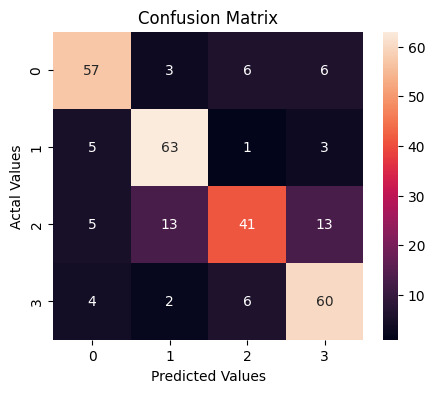

In [ ]:
#Plotting the confusion matrix
cm_df = pd.DataFrame(cm,index = ['0','1','2','3'],columns = ['0','1','2','3'])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

### topoplot

In [ ]:
mne.channels.get_builtin_montages() # get montages

['standard_1005',
 'standard_1020',
 'standard_alphabetic',
 'standard_postfixed',
 'standard_prefixed',
 'standard_primed',
 'biosemi16',
 'biosemi32',
 'biosemi64',
 'biosemi128',
 'biosemi160',
 'biosemi256',
 'easycap-M1',
 'easycap-M10',
 'easycap-M43',
 'EGI_256',
 'GSN-HydroCel-32',
 'GSN-HydroCel-64_1.0',
 'GSN-HydroCel-65_1.0',
 'GSN-HydroCel-128',
 'GSN-HydroCel-129',
 'GSN-HydroCel-256',
 'GSN-HydroCel-257',
 'mgh60',
 'mgh70',
 'artinis-octamon',
 'artinis-brite23',
 'brainproducts-RNP-BA-128']

In [ ]:
# mne doc: https://mne.tools/stable/python_reference.html
# "data_detail.json" in BCI_hw3_dataset/ provides you with all channel names in this dataset. It will help you to plot a topoplot.
channels = ["Fz", "FC3", "FC1", "FCz", "FC2", "FC4", "T7", "C3", "C1", "Cz", "C2", "C4", "T8", "CP3", "CP1", "CPz", "CP2", "CP4", "P1", "Pz", "P2", "POz"]
aa = mne.channels.make_standard_montage('standard_1020', head_size='auto')

In [ ]:
pos = [] # get the channels position (x, y)
for i in channels:
  pos.append([aa.get_positions()["ch_pos"][i][0], aa.get_positions()["ch_pos"][i][1]])

pos = np.array(pos)

[[ 0.0003122  0.058512 ]
 [-0.0601819  0.0227162]
 [-0.0340619  0.0260111]
 [ 0.0003761  0.02739  ]
 [ 0.0347841  0.0264379]
 [ 0.0622931  0.0237228]
 [-0.0841611 -0.0160187]
 [-0.0653581 -0.0116317]
 [-0.036158  -0.0099839]
 [ 0.0004009 -0.009167 ]
 [ 0.037672  -0.0096241]
 [ 0.0671179 -0.0109003]
 [ 0.0850799 -0.0150203]
 [-0.0635562 -0.0470088]
 [-0.0355131 -0.0472919]
 [ 0.0003858 -0.047318 ]
 [ 0.0383838 -0.0470731]
 [ 0.0666118 -0.0466372]
 [-0.0286203 -0.0805249]
 [ 0.0003247 -0.081115 ]
 [ 0.0319197 -0.0804871]
 [ 0.0002156 -0.102178 ]]


In [ ]:
best_epoch = "107" # best model weight
test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", best_epoch))
checkpoint = torch.load(test_model_path, map_location="cpu")
weight = checkpoint["state_dict"]['conv_block1.0.weight']

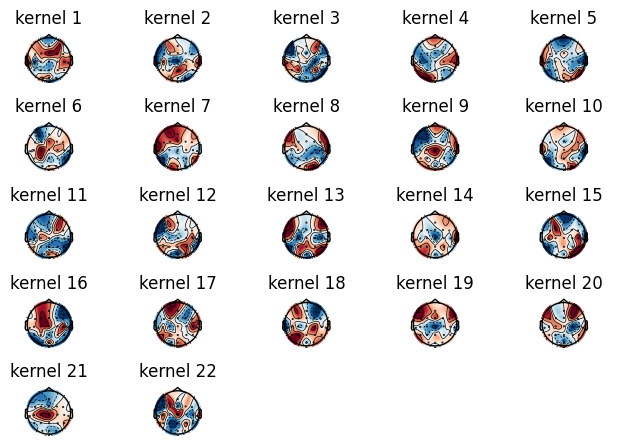

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 5)
for i in range(22):
  a = i / 5
  b = i % 5
  weight = checkpoint["state_dict"]['conv_block1.0.weight'].squeeze()[0][i]
  ax[int(a), b].set_title(f'kernel {i+1}')
  plt.tight_layout()
  mne.viz.plot_topomap(data = weight, pos = pos, axes = ax[int(a), b], show = False)

for i in range(22, 25): # delete extra plot
  a = i / 5
  b = i % 5
  ax[int(a), b].set_axis_off()

plt.show()

## Generate Submission csv File

In [ ]:
eegmodel = SCCNet # function alias, should be EEGNet, SCCNet, SCCNet_v2
# custom args for different EEG model
kwargs = dict(Nt=22, Nc=20, fs=125.0, dropoutRate=0.5) # SCCNet
# kwargs = dict(kernLength=32, F1=16, F2=32, D=4, dropoutRate=0.2) # EEGNet
model = eegmodel(22, 562, 4, **kwargs)
best_epoch = hist["val_loss"].argmin()
test_model_path = os.path.join(savepath, "{}-ep{}.pth".format("TORCH_MODEL_NAME", best_epoch))
checkpoint = torch.load(test_model_path, map_location="cpu")
model.load_state_dict(checkpoint["state_dict"])

model.eval()
fd = open("simple_sd.csv", "w")
csv_writer = csv.writer(fd)
csv_writer.writerow(["id", "Category"])
for sid in ["05", "06", "0A", "0B", "0C"]:
    mat = loadmat(os.path.join(DATASET_DIR_EXAM, f"BCIC_S{sid}_E.mat"))
    x = torch.from_numpy(mat["x_test"])
    x = x.unsqueeze(1).to('cpu', dtype=torch.float)
    p = model(x).argmax(dim=1).detach().cpu().numpy()
    for epoch_id, label in enumerate(p):
        csv_writer.writerow([f"S{sid}_{epoch_id}", label])
fd.close()